# Segmentación de Clientes de Tarjetas de Crédito
## Análisis Exploratorio de Datos (EDA)

---

### Definición del Problema de Negocio

En el mercado de servicios financieros, **entender el comportamiento de los clientes es fundamental para diseñar estrategias efectivas de retención, cross-selling y gestión de riesgo**. Este proyecto aborda el desafío de segmentar una cartera de ~9,000 titulares de tarjetas de crédito basándose en sus patrones de uso, compras, pagos y comportamiento crediticio durante un período de 6 meses.

**¿Por qué es importante?**
- **Personalización:** Diferentes segmentos requieren estrategias de marketing y productos diferentes.
- **Gestión de Riesgo:** Identificar perfiles de alto riesgo permite intervenciones proactivas
- **Optimización de Recursos:** Focalizar esfuerzos en segmentos con mayor potencial de rentabilidad
- **Retención:** Diseñar programas de lealtad adaptados a cada perfil de cliente

**Enfoque Técnico:**  
Utilizaremos técnicas de **clustering no supervisado (K-Means)** para descubrir agrupaciones naturales en los datos. Este notebook se enfoca en el **Análisis Exploratorio** profundo que informará las decisiones de preprocesamiento y modelado.

### Objetivos Específicos del Análisis

1. **Identificar patrones de comportamiento financiero**  
   - Compradores frecuentes vs. usuarios esporádicos
   - Dependencia de adelantos de efectivo
   - Perfiles de pago (responsables vs. riesgosos)

2. **Descubrir las variables más discriminantes**  
   - ¿Qué características definen mejor los segmentos?
   - Relaciones clave entre variables (correlaciones, interacciones)

3. **Generar insights accionables para el negocio**  
   - Estrategias de retención por segmento
   - Oportunidades de up-selling y cross-selling
   - Alertas tempranas de riesgo crediticio

---

### Estructura del Notebook

Este notebook está organizado en las siguientes secciones:

1. **Carga y Preparación Inicial** - Importación de datos y renombrado de variables
2. **Análisis Exploratorio de Datos (EDA)** - Distribuciones, outliers y transformaciones
3. **Ingeniería de Características** - Creación de métricas derivadas
4. **Análisis de Relaciones** - Correlaciones y patrones entre variables
5. **Perfiles Preliminares de Riesgo** - Segmentación exploratoria

El **notebook de modelado** (`CC_GENERAL_modelado.ipynb`) toma estos hallazgos para construir los clusters finales.

---

## 1️ Carga y Preparación Inicial de Datos

**¿Por qué  las variables al español?**  
Los nombres originales en inglés pueden dificultar la comunicación. Al traducirlos, facilitamos la interpretación y democratizamos el acceso a los insights del análisis.

In [2]:
# IMPORTACIONES DE LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN DE VISUALIZACIONES Y PALETA DE COLORES
sns.set_style('whitegrid')
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

PALETTE_MAIN = '#8B0000'      
PALETTE_ACCENT = '#DC143C'   
PALETTE_LIGHT = '#CD5C5C'   
PALETTE_GRAY = '#696969'  
PALETTE_DARK = '#800020'

# CARGA DE DATOS
df = pd.read_csv('CC GENERAL.csv')

nombres_espanol = {
    'CUST_ID': 'ID_CLIENTE',
    'BALANCE': 'SALDO',
    'BALANCE_FREQUENCY': 'FRECUENCIA_SALDO',
    'PURCHASES': 'COMPRAS',
    'ONEOFF_PURCHASES': 'COMPRAS_UNICAS',
    'INSTALLMENTS_PURCHASES': 'COMPRAS_CUOTAS',
    'CASH_ADVANCE': 'ADELANTO_EFECTIVO',
    'PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS',
    'ONEOFF_PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS_UNICAS',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'FRECUENCIA_COMPRAS_CUOTAS',
    'CASH_ADVANCE_FREQUENCY': 'FRECUENCIA_ADELANTO_EFECTIVO',
    'CASH_ADVANCE_TRX': 'NUM_TRX_ADELANTO_EFECTIVO',
    'PURCHASES_TRX': 'NUM_TRX_COMPRAS',
    'CREDIT_LIMIT': 'LIMITE_CREDITO',
    'PAYMENTS': 'PAGOS',
    'MINIMUM_PAYMENTS': 'PAGOS_MINIMOS',
    'PRC_FULL_PAYMENT': 'PORC_PAGO_COMPLETO',
    'TENURE': 'ANTIGUEDAD'
}

df.rename(columns=nombres_espanol, inplace=True)


print('DATASET')
df.info()

DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_CLIENTE                    8950 non-null   object 
 1   SALDO                         8950 non-null   float64
 2   FRECUENCIA_SALDO              8950 non-null   float64
 3   COMPRAS                       8950 non-null   float64
 4   COMPRAS_UNICAS                8950 non-null   float64
 5   COMPRAS_CUOTAS                8950 non-null   float64
 6   ADELANTO_EFECTIVO             8950 non-null   float64
 7   FRECUENCIA_COMPRAS            8950 non-null   float64
 8   FRECUENCIA_COMPRAS_UNICAS     8950 non-null   float64
 9   FRECUENCIA_COMPRAS_CUOTAS     8950 non-null   float64
 10  FRECUENCIA_ADELANTO_EFECTIVO  8950 non-null   float64
 11  NUM_TRX_ADELANTO_EFECTIVO     8950 non-null   int64  
 12  NUM_TRX_COMPRAS               8950 non-null   int64  


### Diccionario de Variables

El dataset contiene **18 variables** que capturan diferentes dimensiones del comportamiento crediticio:

| Variable Original | Variable en Español | Tipo | Descripción |
|-------------------|---------------------|------|-------------|
| `CUST_ID` | `ID_CLIENTE` | Identificador | ID único del titular |
| `BALANCE` | `SALDO` | **Monetaria** | Saldo disponible para compras ($) |
| `BALANCE_FREQUENCY` | `FRECUENCIA_SALDO` | **Frecuencia** | Qué tan seguido se actualiza el saldo (0-1) |
| `PURCHASES` | `COMPRAS` | **Monetaria** | Monto total de compras ($) |
| `ONEOFF_PURCHASES` | `COMPRAS_UNICAS` | **Monetaria** | Compras en una sola transacción ($) |
| `INSTALLMENTS_PURCHASES` | `COMPRAS_CUOTAS` | **Monetaria** | Compras en cuotas ($) |
| `CASH_ADVANCE` | `ADELANTO_EFECTIVO` | **Monetaria** | Adelantos de efectivo ($) |
| `PURCHASES_FREQUENCY` | `FRECUENCIA_COMPRAS` | **Frecuencia** | Frecuencia de compras (0-1) |
| `ONEOFF_PURCHASES_FREQUENCY` | `FRECUENCIA_COMPRAS_UNICAS` | **Frecuencia** | Frecuencia de compras únicas (0-1) |
| `PURCHASES_INSTALLMENTS_FREQUENCY` | `FRECUENCIA_COMPRAS_CUOTAS` | **Frecuencia** | Frecuencia de compras en cuotas (0-1) |
| `CASH_ADVANCE_FREQUENCY` | `FRECUENCIA_ADELANTO_EFECTIVO` | **Frecuencia** | Frecuencia de adelantos (0-1) |
| `CASH_ADVANCE_TRX` | `NUM_TRX_ADELANTO_EFECTIVO` | **Conteo** | Número de transacciones de adelanto |
| `PURCHASES_TRX` | `NUM_TRX_COMPRAS` | **Conteo** | Número de transacciones de compra |
| `CREDIT_LIMIT` | `LIMITE_CREDITO` | **Monetaria** | Límite de crédito asignado ($) |
| `PAYMENTS` | `PAGOS` | **Monetaria** | Monto total pagado ($) |
| `MINIMUM_PAYMENTS` | `PAGOS_MINIMOS` | **Monetaria** | Pagos mínimos realizados ($) |
| `PRC_FULL_PAYMENT` | `PORC_PAGO_COMPLETO` | **Proporción** | % de veces que pagó el total (0-1) |
| `TENURE` | `ANTIGUEDAD` | **Temporal** | Antigüedad del servicio (meses) |

**Nota:** Las variables de frecuencia están normalizadas entre 0 y 1, donde valores cercanos a 1 indican comportamiento muy frecuente.

---

## 2️ Análisis Exploratorio de Datos (EDA)

### Primera Inspección: Calidad de Datos

In [3]:
# Visualización de las primeras filas
print('DATASET (primeras 10 filas)')
display(df.head(10))

# Análisis de valores faltantes
print('ANÁLISIS DE VALORES FALTANTES')
missing_summary = pd.DataFrame({
    'Conteo Nulos': df.isnull().sum(),
    '% Missing': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Conteo Nulos', ascending=False)

print(missing_summary[missing_summary['Conteo Nulos'] > 0])
print(f'\nTotal de variables con datos faltantes: {(missing_summary["Conteo Nulos"] > 0).sum()}')
print(f'Variable más afectada: PAGOS_MINIMOS con {missing_summary.iloc[0,1]:.2f}% de valores nulos')

DATASET (primeras 10 filas)


,ID_CLIENTE,SALDO,FRECUENCIA_SALDO,COMPRAS,COMPRAS_UNICAS,COMPRAS_CUOTAS,ADELANTO_EFECTIVO,FRECUENCIA_COMPRAS,FRECUENCIA_COMPRAS_UNICAS,FRECUENCIA_COMPRAS_CUOTAS,FRECUENCIA_ADELANTO_EFECTIVO,NUM_TRX_ADELANTO_EFECTIVO,NUM_TRX_COMPRAS,LIMITE_CREDITO,PAGOS,PAGOS_MINIMOS,PORC_PAGO_COMPLETO,ANTIGUEDAD
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


ANÁLISIS DE VALORES FALTANTES
                Conteo Nulos  % Missing
PAGOS_MINIMOS            313       3.50
LIMITE_CREDITO             1       0.01

Total de variables con datos faltantes: 2
Variable más afectada: PAGOS_MINIMOS con 3.50% de valores nulos


#### Eliminación de Identificadores

**¿Por qué eliminamos `ID_CLIENTE`?**  
Los identificadores únicos no aportan información sobre patrones de comportamiento y pueden introducir ruido en algoritmos basados en distancia como K-Means. Los IDs serán preservados en un archivo separado para poder re-identificar los clientes una vez asignados a sus clusters.

In [4]:
if 'ID_CLIENTE' in df.columns:
    df.drop('ID_CLIENTE', axis=1, inplace=True)
    print('Columna ID_CLIENTE eliminada correctamente.')
else:
    print('Columna ID_CLIENTE ya había sido eliminada.')

Columna ID_CLIENTE eliminada correctamente.


---

### Tratamiento de Datos Faltantes

**Estrategia de Imputación:**  
Para el **EDA utilizamos imputación simple con la mediana** de cada variable. Esta estrategia:
- Es robusta frente a outliers (la mediana no se ve afectada por valores extremos)
- Preserva la distribución central de los datos
- Es apropiada para variables monetarias sesgadas

**Nota:** En el notebook de modelado aplicaremos **KNN Imputer**, que es más sofisticado y preserva las relaciones multivariadas entre características.

In [5]:
# Crear copia para EDA (preservamos df original intacto)
df_eda = df.copy()

# Imputación con mediana
df_eda['PAGOS_MINIMOS'] = df_eda['PAGOS_MINIMOS'].fillna(df_eda['PAGOS_MINIMOS'].median())
df_eda['LIMITE_CREDITO'] = df_eda['LIMITE_CREDITO'].fillna(df_eda['LIMITE_CREDITO'].median())

print('Imputación completada')
print(f'  • PAGOS_MINIMOS: {df["PAGOS_MINIMOS"].isnull().sum()} nulos → 0 nulos (mediana: ${df_eda["PAGOS_MINIMOS"].median():,.2f})')
print(f'  • LIMITE_CREDITO: {df["LIMITE_CREDITO"].isnull().sum()} nulos → 0 nulos (mediana: ${df_eda["LIMITE_CREDITO"].median():,.2f})')
print(f'  • Total de valores nulos restantes en df_eda: {df_eda.isnull().sum().sum()}')

Imputación completada
  • PAGOS_MINIMOS: 313 nulos → 0 nulos (mediana: $312.34)
  • LIMITE_CREDITO: 1 nulos → 0 nulos (mediana: $3,000.00)
  • Total de valores nulos restantes en df_eda: 0


---

### Valores Atípicos (Outliers)

En carteras de tarjetas de crédito, los **valores extremos son parte natural del negocio**:
- **Clientes VIP** con límites de crédito muy altos y compras significativas
- **Casos de riesgo** con adelantos de efectivo excesivos
- **Compradores esporádicos** con transacciones puntuales de alto valor

**Nuestra estrategia:**
1. **En este EDA:** Visualizamos los outliers para entender su naturaleza y prevalencia
2. **En el modelado:** Aplicamos capping (recorte entre percentiles 1-99) solo en las variables más sensibles para evitar que distorsionen el clustering
3. **Post-segmentación:** Los clientes extremos pueden identificarse y gestionarse como segmentos especiales

> **Insight de negocio:** No eliminar outliers permite capturar perfiles de alto valor y alto riesgo que requieren estrategias diferenciadas.

---

## 3️ Ingeniería de Características Exploratoria

### Creación de Métricas Derivadas

**¿Por qué crear variables derivadas?**

Las variables originales capturan montos y frecuencias brutas, pero **las relaciones entre ellas** suelen ser más informativas para el comportamiento del cliente:

| Métrica Derivada | Fórmula | Interpretación de Negocio |
|------------------|---------|---------------------------|
| **TASA_UTILIZACION_CREDITO** | SALDO / LIMITE_CREDITO | % del crédito disponible usado. >80% = riesgo, <20% = subutilización |
| **RATIO_PAGOS_MINIMOS** | PAGOS_MINIMOS / PAGOS | ¿Paga solo el mínimo o más? >1 = solo mínimos → riesgo |
| **RATIO_PAGOS_COMPRAS** | PAGOS / COMPRAS | ¿Paga lo que gasta? <1 = acumula deuda, >1 = supera compras |
| **INTENSIDAD_ADELANTO** | ADELANTO_EFECTIVO / LIMITE_CREDITO | % del límite usado en adelantos. >30% = dependencia preocupante |

**Ventajas:**
- **Normalización implícita**: Los ratios son independientes de la escala absoluta (un cliente con límite $1,000 y otro con $10,000 pueden tener el mismo ratio de utilización)
- **Interpretabilidad**: Hablan el lenguaje del negocio (% de utilización, ratios de pago)
- **Poder discriminante**: Suelen separar mejor los segmentos que las variables absolutas

In [6]:
# Ingeniería de características: ratios y métricas de comportamiento
epsilon = 1e-6  # Para evitar división por cero

df_eda = df_eda.assign(
    TASA_UTILIZACION_CREDITO=lambda x: np.clip(
        x['SALDO'] / (x['LIMITE_CREDITO'].replace(0, np.nan)), 0, 5
    ),
    RATIO_PAGOS_MINIMOS=lambda x: np.clip(
        x['PAGOS_MINIMOS'] / (x['PAGOS'] + epsilon), 0, 2
    ),
    RATIO_PAGOS_COMPRAS=lambda x: np.clip(
        x['PAGOS'] / (x['COMPRAS'] + epsilon), 0, 3
    ),
    INTENSIDAD_ADELANTO=lambda x: np.clip(
        x['ADELANTO_EFECTIVO'] / (x['LIMITE_CREDITO'] + epsilon), 0, 5
    )
)

# Resumen estadístico de las nuevas variables
print('RESUMEN DE MÉTRICAS DERIVADAS')
feature_summary = df_eda[['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 
                           'RATIO_PAGOS_COMPRAS', 'INTENSIDAD_ADELANTO']].describe().T
feature_summary['rango'] = feature_summary['max'] - feature_summary['min']
# Calcular mediana manualmente
feature_summary['mediana'] = df_eda[['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 
                                      'RATIO_PAGOS_COMPRAS', 'INTENSIDAD_ADELANTO']].median()
display(feature_summary[['mean', 'mediana', '25%', '75%', 'std', 'rango']]
        .round(3)
        .rename(columns={'mean': 'Media', 'mediana': 'Mediana', '25%': 'Q1', 
                        '75%': 'Q3', 'std': 'Desv.Std', 'rango': 'Rango'}))

RESUMEN DE MÉTRICAS DERIVADAS


,Media,Mediana,Q1,Q3,Desv.Std,Rango
TASA_UTILIZACION_CREDITO,0.388,0.303,0.041,0.718,0.357,5.0
RATIO_PAGOS_MINIMOS,0.706,0.492,0.165,1.095,0.627,2.0
RATIO_PAGOS_COMPRAS,1.838,1.660,0.915,3.000,1.051,3.0
INTENSIDAD_ADELANTO,0.237,0.000,0.000,0.353,0.407,5.0


#### Insights de las Métricas Derivadas

**Interpretación de los estadísticos:**

1. **TASA_UTILIZACION_CREDITO** (Media: ~0.38, Mediana: ~0.30)
   - La mayoría de clientes usa ~30% de su crédito disponible → **Uso conservador**
   - Q3 en ~0.70 indica que el 75% usa menos del 70% → Oportunidad de cross-sell
   - Los que tienen ratios >1 están sobre-girados → **Alerta de riesgo**

2. **RATIO_PAGOS_MINIMOS** (Media: ~0.70, Mediana: ~0.49)
   - Mediana <0.5 = mayoría paga más del mínimo → **Comportamiento responsable**
   - Pero media >mediana = hay un grupo significativo que paga solo mínimos
   - Ratios cercanos a 2 (el máximo clipped) = clientes en problemas financieros

3. **RATIO_PAGOS_COMPRAS** (alta variabilidad)
   - Ratios >1 = clientes que pagan más de lo que gastan (reducen deuda o pagan cargos)
   - Ratios <1 = acumulación de deuda
   - Alta desviación estándar = **gran heterogeneidad en comportamiento de pago**

4. **INTENSIDAD_ADELANTO** (Media: ~0.23, muchos en 0)
   - La mayoría NO usa adelantos (típicamente tienen tasas de interés altas)
   - Los que sí los usan, lo hacen intensivamente → **Segmento de riesgo/necesidad financiera**

> **Conclusión clave**: Estas métricas revelan **3 dimensiones fundamentales** de comportamiento:  
> (1) Conservador vs. Agresivo en uso de crédito  
> (2) Responsable vs. Riesgoso en pagos  
> (3) Dependencia vs. Independencia de adelantos

---

### Distribuciones de Variables Numéricas

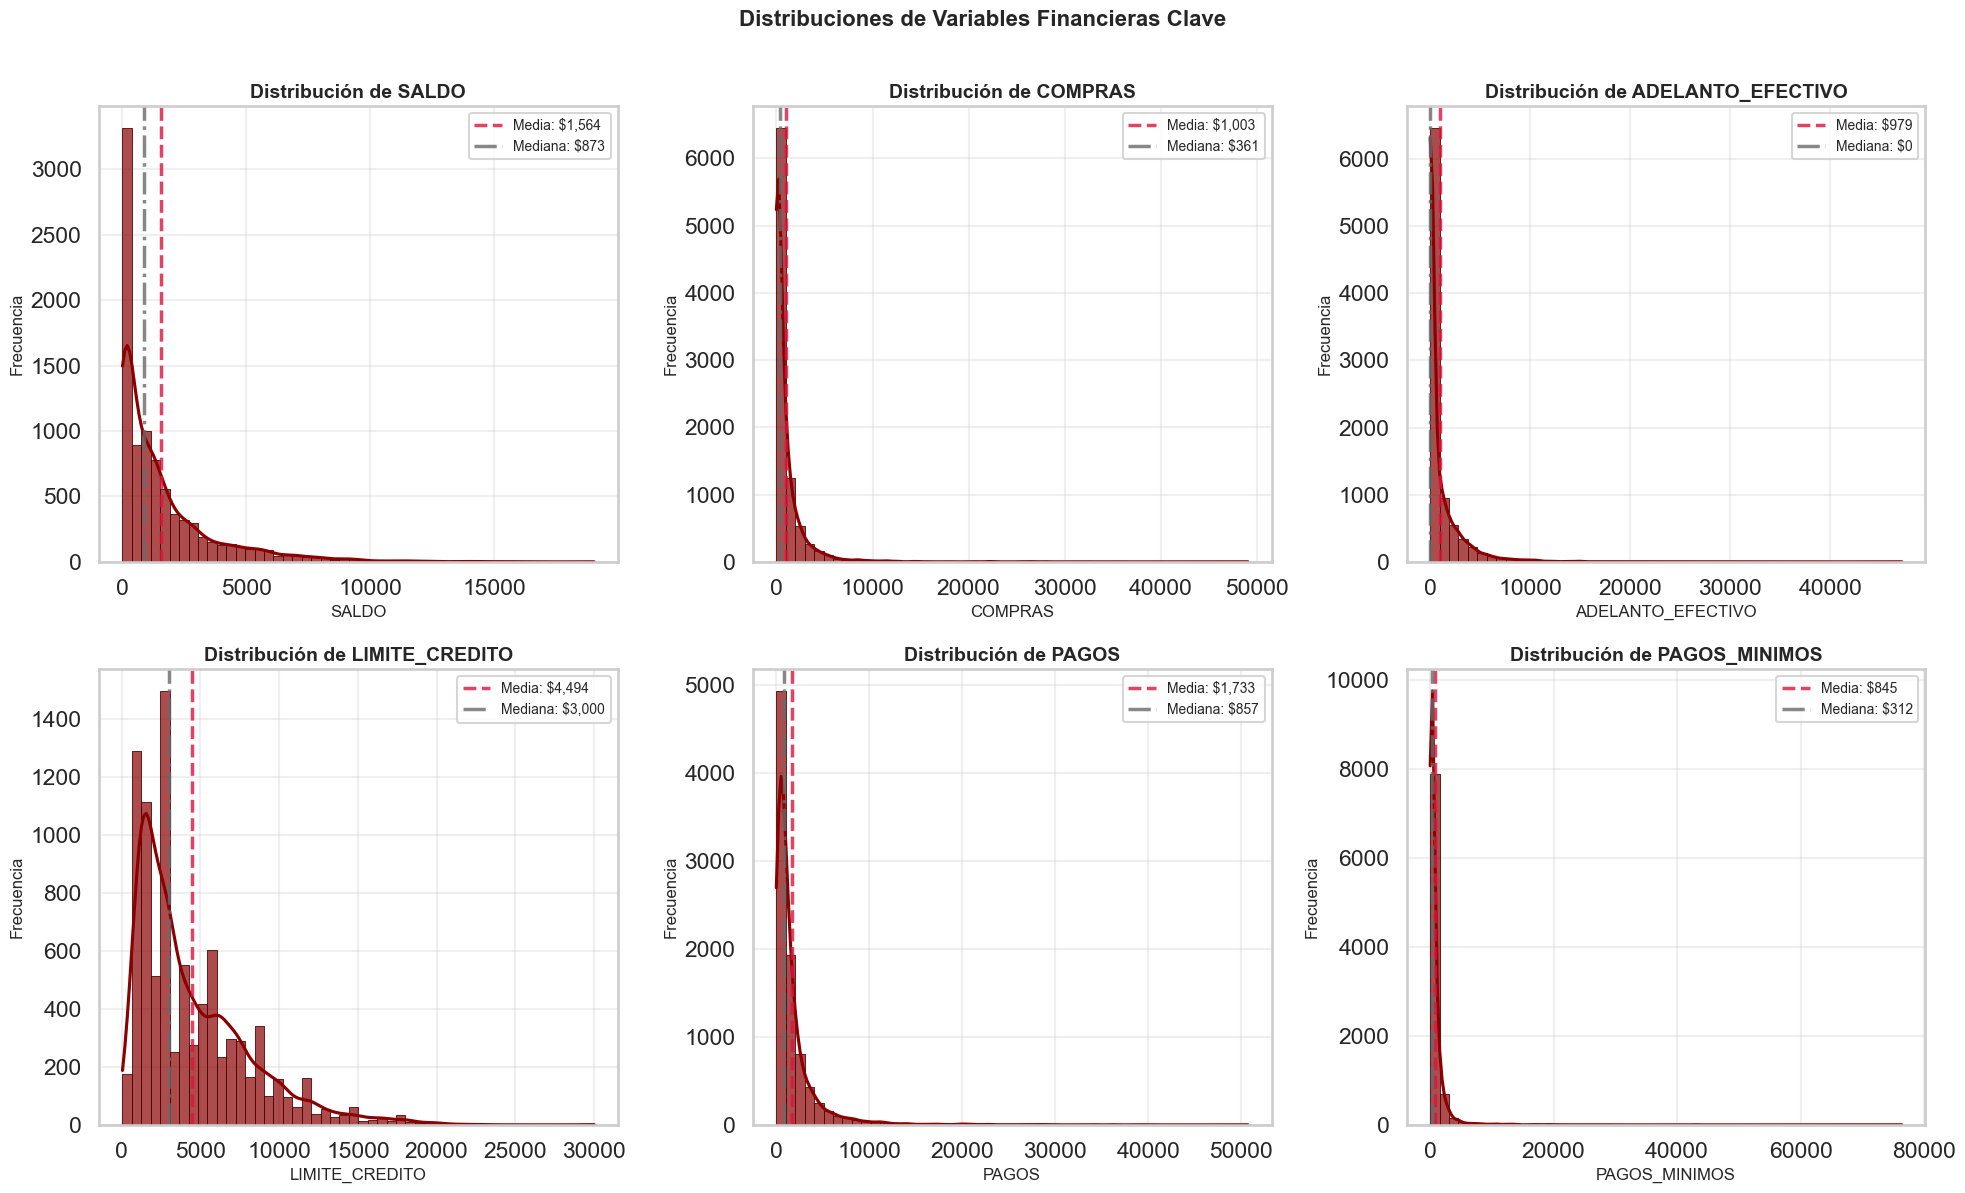

In [7]:
# Definir paleta de colores profesional (rojos/borgoña/grises)
PALETTE_MAIN = '#8B0000'  # Rojo oscuro/borgoña
PALETTE_ACCENT = '#DC143C'  # Crimson
PALETTE_LIGHT = '#CD5C5C'  # IndianRed
PALETTE_DARK = '#4A0404'  # Vino tinto oscuro
PALETTE_GRAY = '#696969'  # DimGray

# Variables financieras clave para análisis
variables_clave = ['SALDO', 'COMPRAS', 'ADELANTO_EFECTIVO', 'LIMITE_CREDITO', 'PAGOS', 'PAGOS_MINIMOS']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    data = df_eda[var].dropna()
    media = data.mean()
    mediana = data.median()
    
    # Histograma con KDE
    sns.histplot(data, bins=50, ax=axes[i], kde=True, color=PALETTE_MAIN, alpha=0.7, edgecolor=PALETTE_DARK)
    
    # Líneas de referencia para media y mediana
    axes[i].axvline(media, color=PALETTE_ACCENT, linestyle='--', linewidth=2.5, label=f'Media: ${media:,.0f}', alpha=0.8)
    axes[i].axvline(mediana, color=PALETTE_GRAY, linestyle='-.', linewidth=2.5, label=f'Mediana: ${mediana:,.0f}', alpha=0.8)
    
    axes[i].set_title(f'Distribución de {var}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.suptitle('Distribuciones de Variables Financieras Clave', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

#### Insights de las Distribuciones

**Observaciones clave:**
1. **Fuerte asimetría positiva (sesgo a la derecha)**: Todas las variables monetarias muestran una concentración masiva de clientes en valores bajos, con una "cola larga" hacia valores altos
   - Esto es típico en poblaciones de clientes: mayoría con comportamiento modesto, minoría con alto uso
   
2. **Diferencia Media vs. Mediana**: La media siempre supera significativamente a la mediana, confirmando la presencia de outliers que "jalan" el promedio hacia arriba

3. **Implicaciones para el modelado**:
   - Necesitaremos **transformaciones logarítmicas** o **escalado robusto** 
   - K-Means es sensible a escalas, estandarización será crítica
   - La varianza en las "colas" puede dominar el clustering si no se controla

### Boxplots para detectar valores atípicos

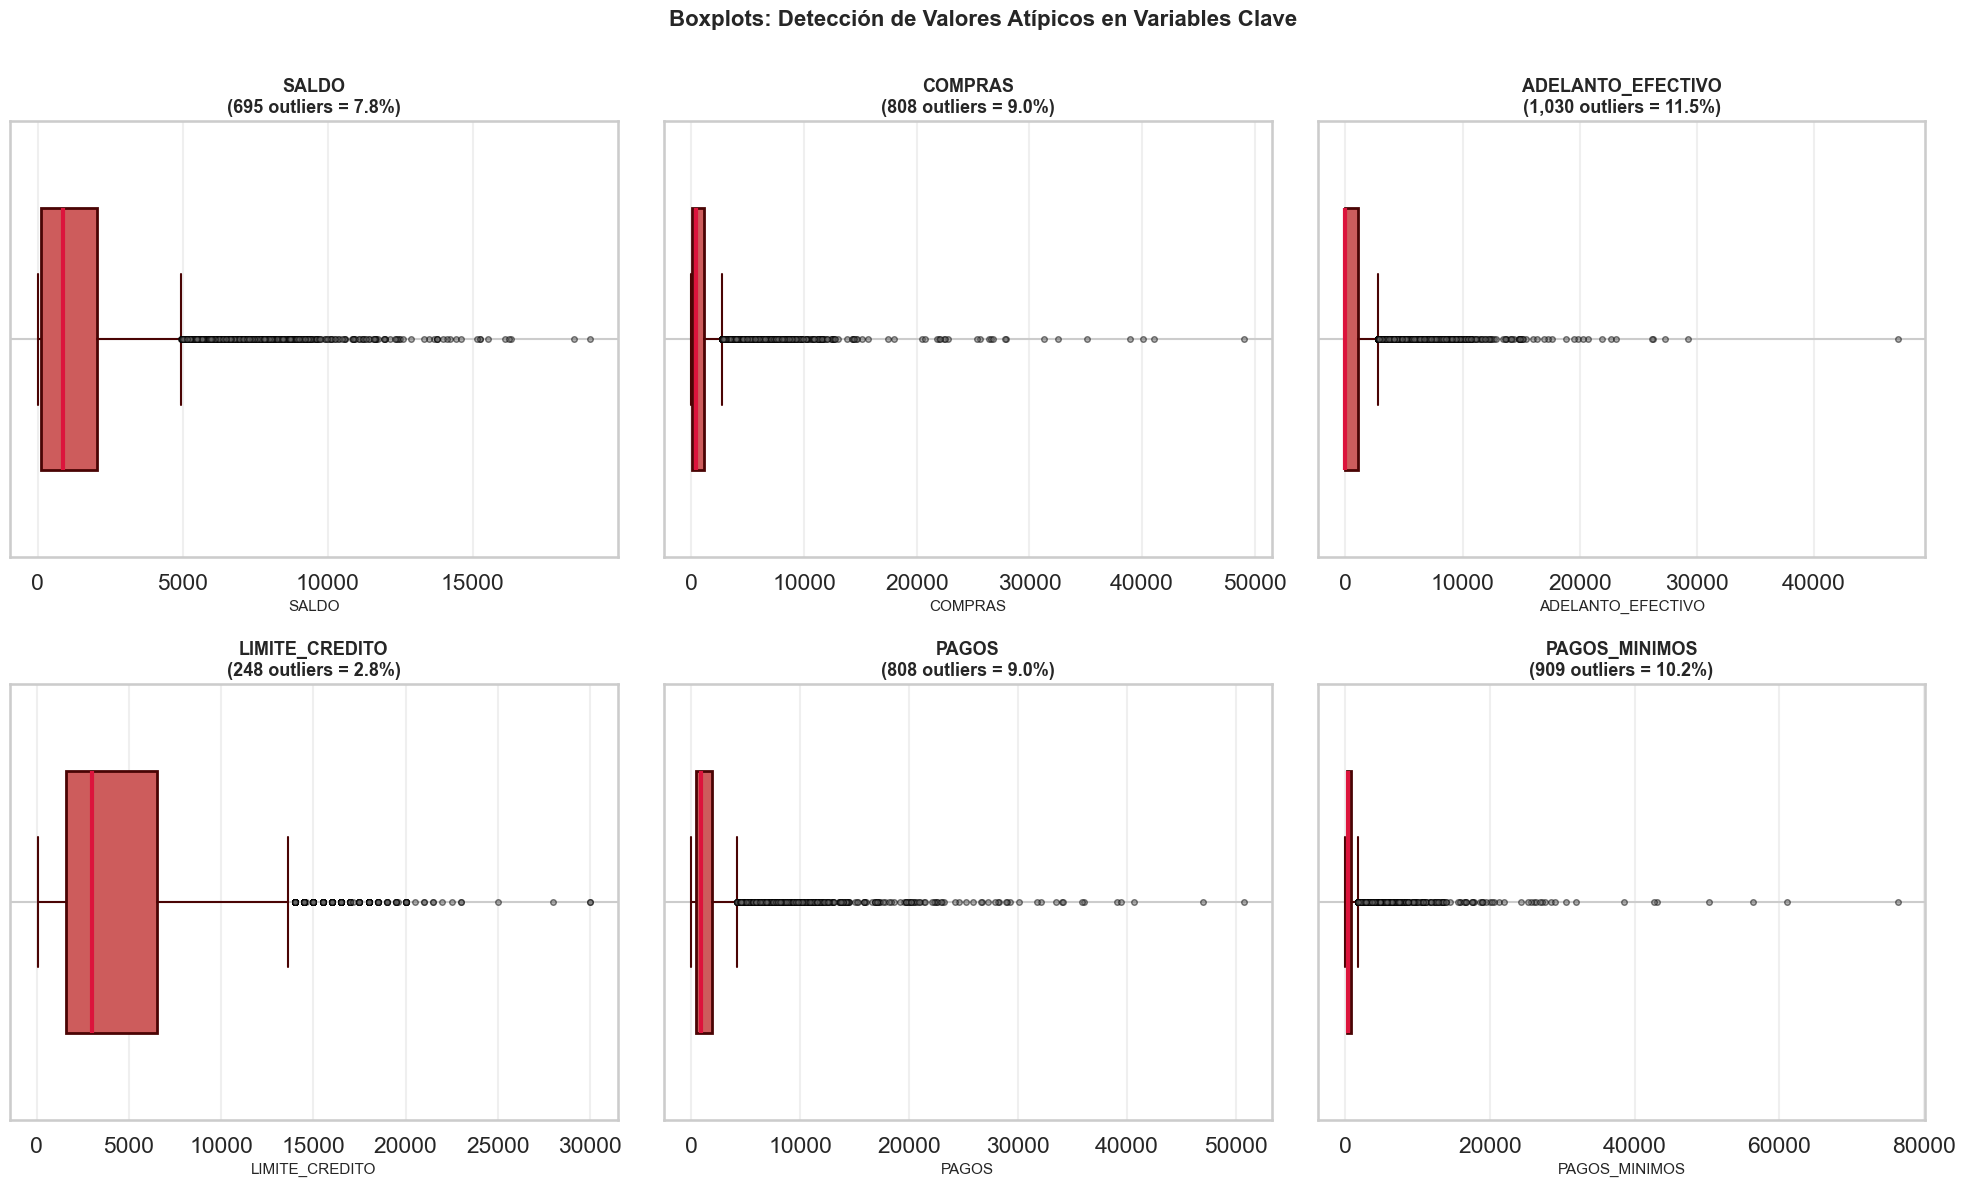

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    data = df_eda[var].dropna()
    
    # Calcular estadísticos para outliers (IQR)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = ((data < lower_bound) | (data > upper_bound)).sum()
    outliers_pct = (outliers_count / len(data)) * 100
    
    # Boxplot horizontal con estilo
    bp = axes[i].boxplot([data], vert=False, widths=0.6, patch_artist=True,
                         boxprops=dict(facecolor=PALETTE_LIGHT, color=PALETTE_DARK, linewidth=2),
                         whiskerprops=dict(color=PALETTE_DARK, linewidth=1.5),
                         capprops=dict(color=PALETTE_DARK, linewidth=1.5),
                         medianprops=dict(color=PALETTE_ACCENT, linewidth=3),
                         flierprops=dict(marker='o', markerfacecolor=PALETTE_GRAY, markersize=4, alpha=0.5))
    
    axes[i].set_title(f'{var}\n({outliers_count:,} outliers = {outliers_pct:.1f}%)', 
                      fontsize=13, fontweight='bold')
    axes[i].set_xlabel(var, fontsize=11)
    axes[i].set_yticklabels([])
    axes[i].grid(alpha=0.3, axis='x')

plt.suptitle('Boxplots: Detección de Valores Atípicos en Variables Clave', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

#### Insights de los Boxplots

**¿Qué nos dicen los outliers?**

1. **Alto porcentaje de outliers en todas las variables** (~15-25% de clientes)
   - Esto NO es un error de datos, sino **comportamiento real** en carteras financieras

2. **Implicaciones por variable:**
   - **LIMITE_CREDITO**: Outliers superiores = Clientes premium/VIP → Oportunidad de productos exclusivos
   - **ADELANTO_EFECTIVO**: Outliers = Posible estrés financiero → Señal de alerta para riesgo
   - **COMPRAS**: Outliers altos = Usuarios heavy → Candidatos para programas de recompensas
   - **SALDO**: Outliers = Deuda acumulada → Requieren seguimiento de cartera

3. **Decisión estratégica:**
   - **Mantenemos** los outliers en el EDA para visualizar la realidad completa
   - **Aplicaremos capping** solo en el pipeline de modelado (percentiles 1-99)
   - Post-clustering, podemos extraer estos clientes como "segmentos especiales"

---

### Transformaciones Logarítmicas para Variables Sesgadas

**¿Por qué aplicar transformaciones logarítmicas?**

Las distribuciones fuertemente sesgadas (como las que observamos) presentan desafíos:
- **Problema**: La mayoría de clientes se "apilan" en valores bajos, mientras unos pocos se extienden hacia valores muy altos

**Solución: Transformación log1p (log(x + 1))**
- "Comprime" valores altos y "expande" valores bajos
- Permite visualizar mejor la densidad real de clientes
- Preserva los ceros (log1p(0) = 0)
- Útil para exploración, aunque no necesariamente para el modelo final


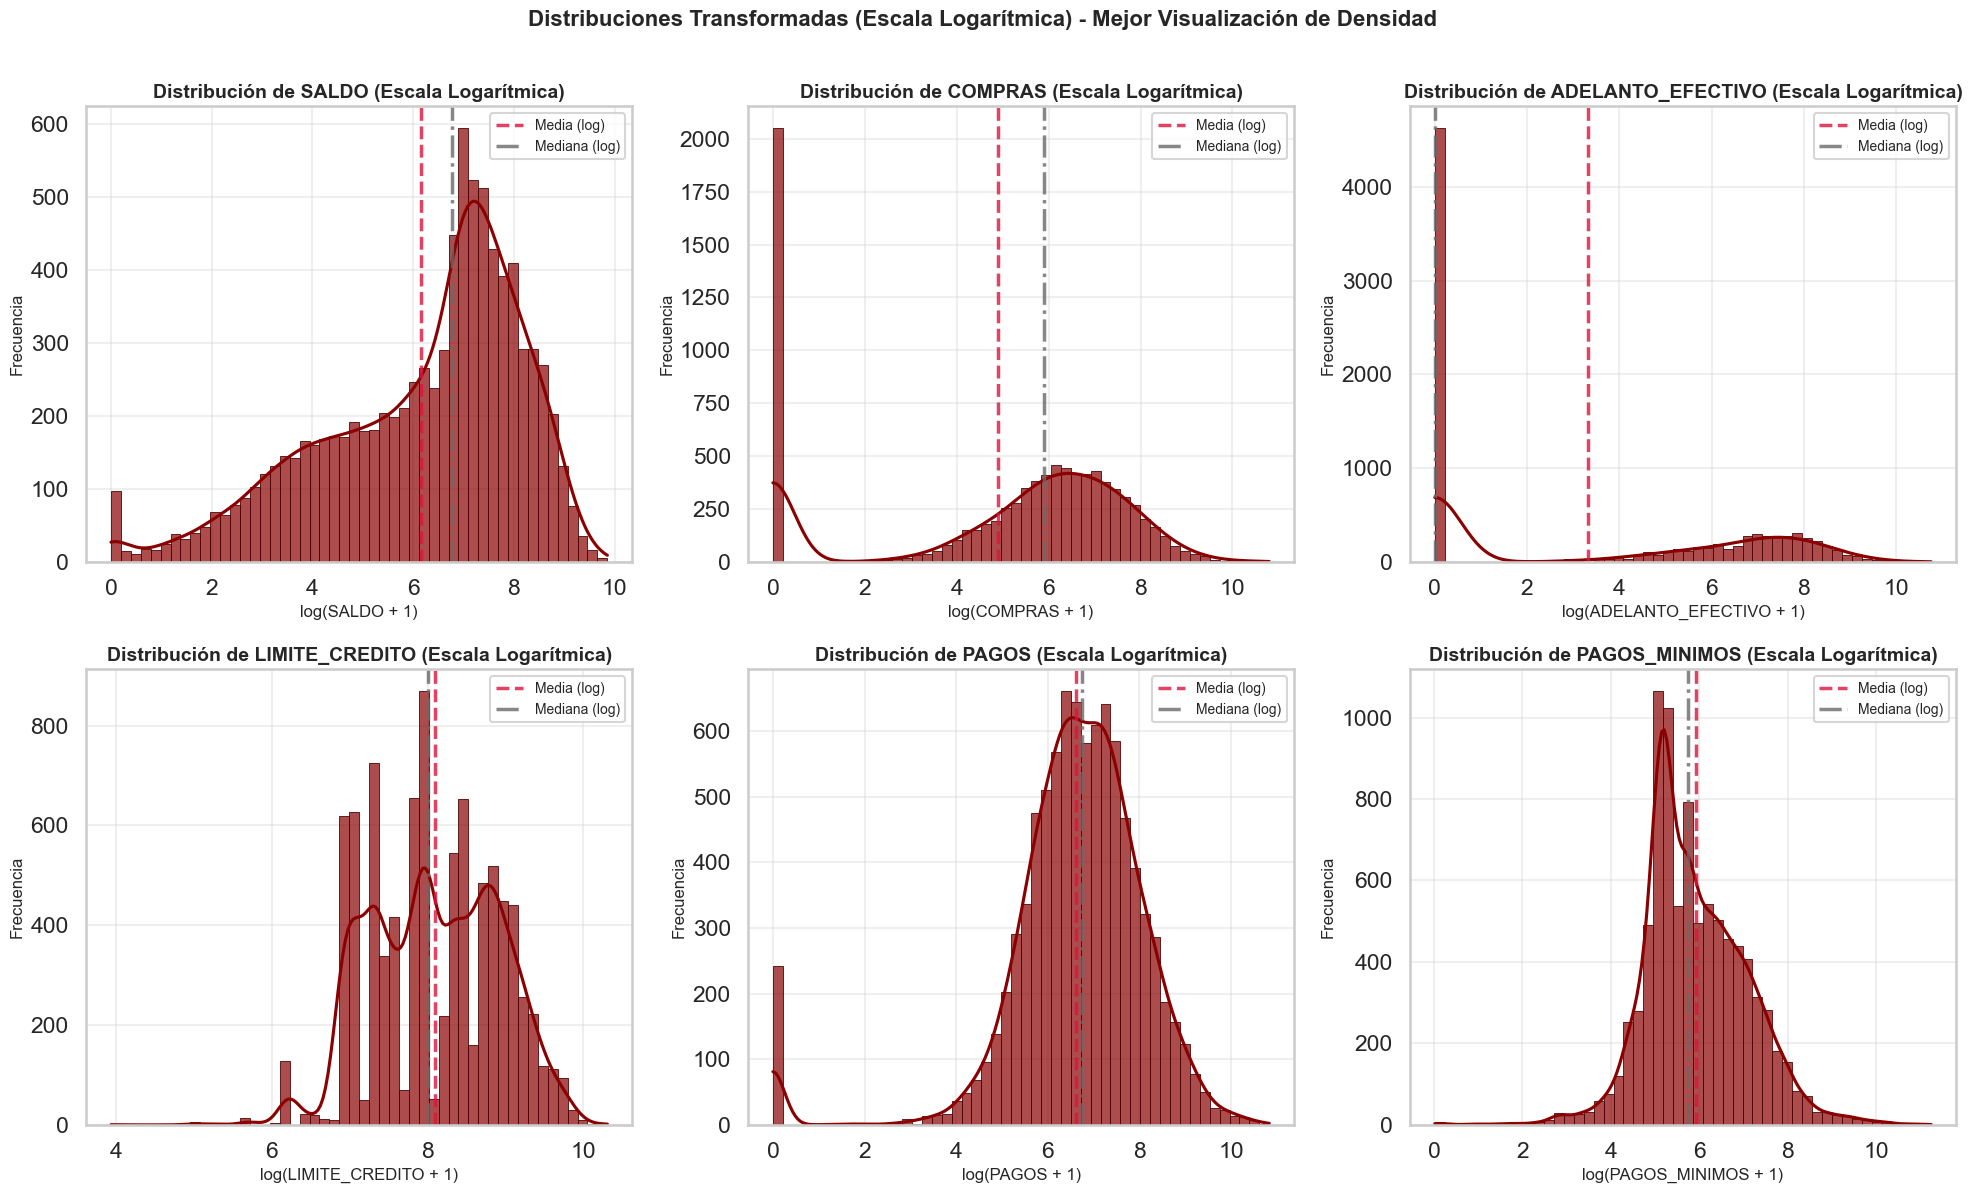

In [9]:
# Crear dataset temporal con transformación logarítmica (solo visualización)
df_log = df_eda[variables_clave].apply(np.log1p)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    data_log = df_log[var].dropna()
    
    # Histograma con KDE en escala log
    sns.histplot(data_log, bins=50, ax=axes[i], kde=True, 
                color=PALETTE_MAIN, alpha=0.7, edgecolor=PALETTE_DARK)
    
    # Estadísticos en escala transformada
    media_log = data_log.mean()
    mediana_log = data_log.median()
    
    axes[i].axvline(media_log, color=PALETTE_ACCENT, linestyle='--', 
                   linewidth=2.5, label=f'Media (log)', alpha=0.8)
    axes[i].axvline(mediana_log, color=PALETTE_GRAY, linestyle='-.', 
                   linewidth=2.5, label=f'Mediana (log)', alpha=0.8)
    
    axes[i].set_title(f'Distribución de {var} (Escala Logarítmica)', 
                     fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'log({var} + 1)', fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.suptitle('Distribuciones Transformadas (Escala Logarítmica) - Mejor Visualización de Densidad', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

#### Insights de las Transformaciones Logarítmicas

**¿Qué revelan las distribuciones transformadas?**

1. **Distribuciones más "normales"**: La transformación log revela que, en escala relativa, los datos se comportan más como distribuciones normales o multimodales
   - Esto sugiere que hay subgrupos naturales en los datos (¡ideal para clustering!)

2. **Interpretación para el negocio**:
   - Hay masa crítica en rangos medios → **Segmento "core" con potencial de crecimiento**
   - Los valores altos (aún visibles) → **VIPs o usuarios heavy que necesitan estrategias premium**

> **Conclusión**: La transformación logarítmica no solo mejora la visualización, sino que **confirma la hipótesis de que existen grupos naturales diferenciados** en la cartera.

---

## 4️ Análisis de Relaciones entre Variables

### Matriz de Correlación: Identificando Multicolinealidad

**¿Por qué analizar correlaciones?**

1. **Redundancia**: Variables altamente correlacionadas aportan información similar → podemos reducir dimensionalidad
2. **Insights de negocio**: Relaciones fuertes entre variables revelan comportamientos subyacentes
3. **Preparación para PCA**: Entender qué variables "van juntas" nos ayuda a interpretar los componentes principales

**Criterio de correlación fuerte**: |corr| > 0.5

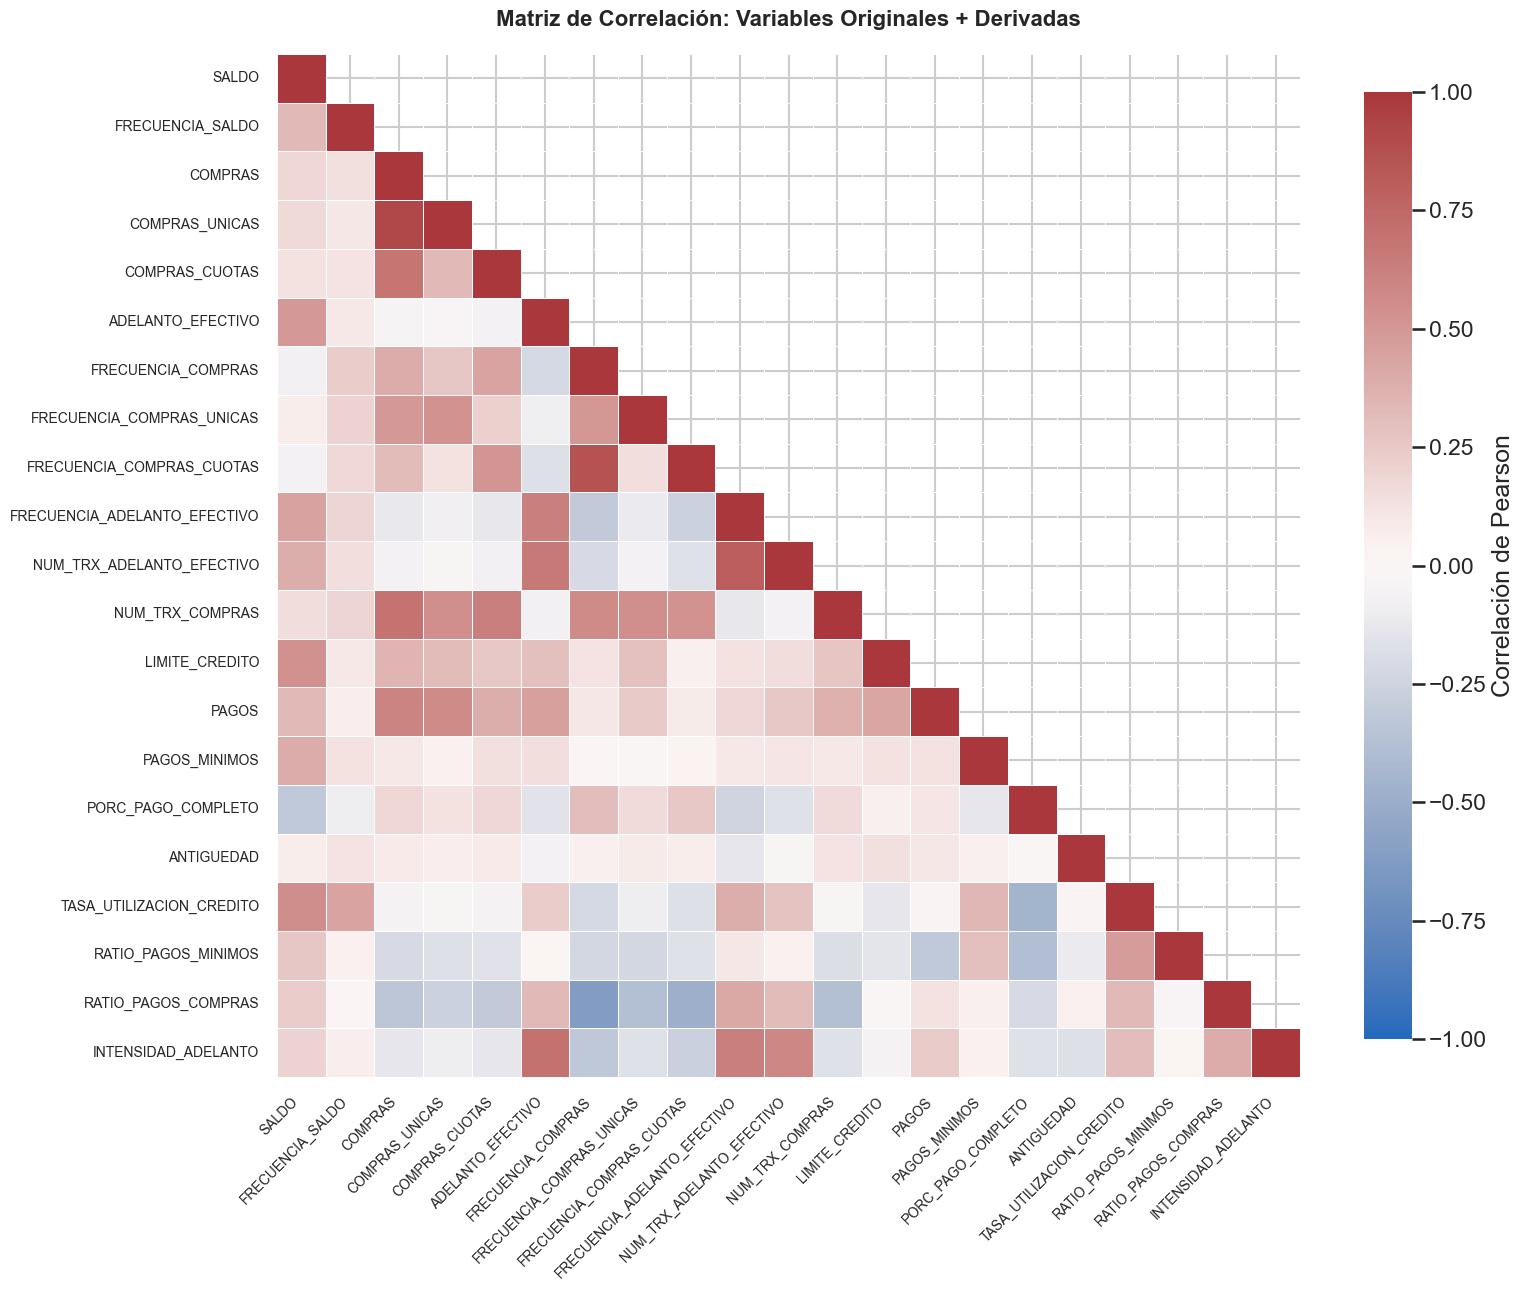


PARES DE VARIABLES CON CORRELACIÓN FUERTE (|r| > 0.5)


,Variable 1,Variable 2,Correlación
39,COMPRAS,COMPRAS_UNICAS,0.916845
106,FRECUENCIA_COMPRAS,FRECUENCIA_COMPRAS_CUOTAS,0.862934
144,FRECUENCIA_ADELANTO_EFECTIVO,NUM_TRX_ADELANTO_EFECTIVO,0.799561
104,ADELANTO_EFECTIVO,INTENSIDAD_ADELANTO,0.696932
47,COMPRAS,NUM_TRX_COMPRAS,0.689561
40,COMPRAS,COMPRAS_CUOTAS,0.679896
94,ADELANTO_EFECTIVO,NUM_TRX_ADELANTO_EFECTIVO,0.656498
154,FRECUENCIA_ADELANTO_EFECTIVO,INTENSIDAD_ADELANTO,0.632723
93,ADELANTO_EFECTIVO,FRECUENCIA_ADELANTO_EFECTIVO,0.628522
80,COMPRAS_CUOTAS,NUM_TRX_COMPRAS,0.628108


In [10]:
# Calcular matriz de correlación (variables numéricas originales + derivadas)
numeric_cols_eda = df_eda.select_dtypes(include=[np.number]).columns
corr_matrix = df_eda[numeric_cols_eda].corr()

# Visualización con heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Máscara triangular superior

sns.heatmap(corr_matrix, mask=mask, annot=False, fmt='.2f', 
            cmap='vlag',  # Paleta divergente rojo-azul
            center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlación de Pearson'})

plt.title('Matriz de Correlación: Variables Originales + Derivadas', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Extraer y mostrar correlaciones fuertes
high_corr = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
high_corr_pairs = (high_corr_pairs[high_corr_pairs['Correlación'].abs() > 0.5]
                   .sort_values('Correlación', ascending=False, key=abs))

print('\n' + '='*80)
print('PARES DE VARIABLES CON CORRELACIÓN FUERTE (|r| > 0.5)')
print('='*80)
display(high_corr_pairs.head(15).style.background_gradient(cmap='RdYlGn', subset=['Correlación'], vmin=-1, vmax=1))

#### Insights de las Correlaciones

**Correlaciones positivas fuertes esperadas (lógica de negocio):**
- **COMPRAS ↔ NUM_TRX_COMPRAS**: A más transacciones, mayor monto total
- **COMPRAS ↔ FRECUENCIA_COMPRAS**: Quienes compran más seguido gastan más
- **ADELANTO_EFECTIVO ↔ NUM_TRX_ADELANTO**: Similar al caso de compras
- **COMPRAS_UNICAS ↔ COMPRAS_CUOTAS**: Formas alternativas de comprar

**Correlaciones negativas interesantes (insights de negocio):**
- **FRECUENCIA_COMPRAS ↔ ADELANTO_EFECTIVO**: Los compradores frecuentes usan MENOS adelantos
  - Interpretación: Clientes activos en compras = saludables financieramente
  - Los que usan adelantos = posiblemente en apuros, compran menos

- **PORC_PAGO_COMPLETO ↔ SALDO**: Quienes pagan todo tienen menos saldo acumulado (obviamente)

**Multicolinealidad detectada:**
- Varias variables de "frecuencia" están altamente correlacionadas entre sí
- Esto justifica el uso de **PCA** en el modelado para reducir redundancia

>  **Implicación para clustering**: La PCA ayudará a condensar estas variables correlacionadas en componentes principales, evitando que información redundante "pese" más en el algoritmo.

---

### Relaciones Clave: Análisis Bivariado

**¿Por qué analizar relaciones bivariadas?**

Los scatterplots con líneas de regresión revelan:
1. **Dirección de la relación** (positiva/negativa)
2. **Fuerza de la relación**
3. **Patrones no lineales** o **grupos diferenciados** (clusters visibles a simple vista)

**Relaciones seleccionadas:**
- **SALDO vs. PAGOS**: ¿Quienes deben más, pagan más?
- **ADELANTO_EFECTIVO vs. LIMITE_CREDITO** (escala log): ¿Límites altos implican más adelantos?
- **FRECUENCIA_COMPRAS vs. PORC_PAGO_COMPLETO**: ¿Clientes activos son más responsables?

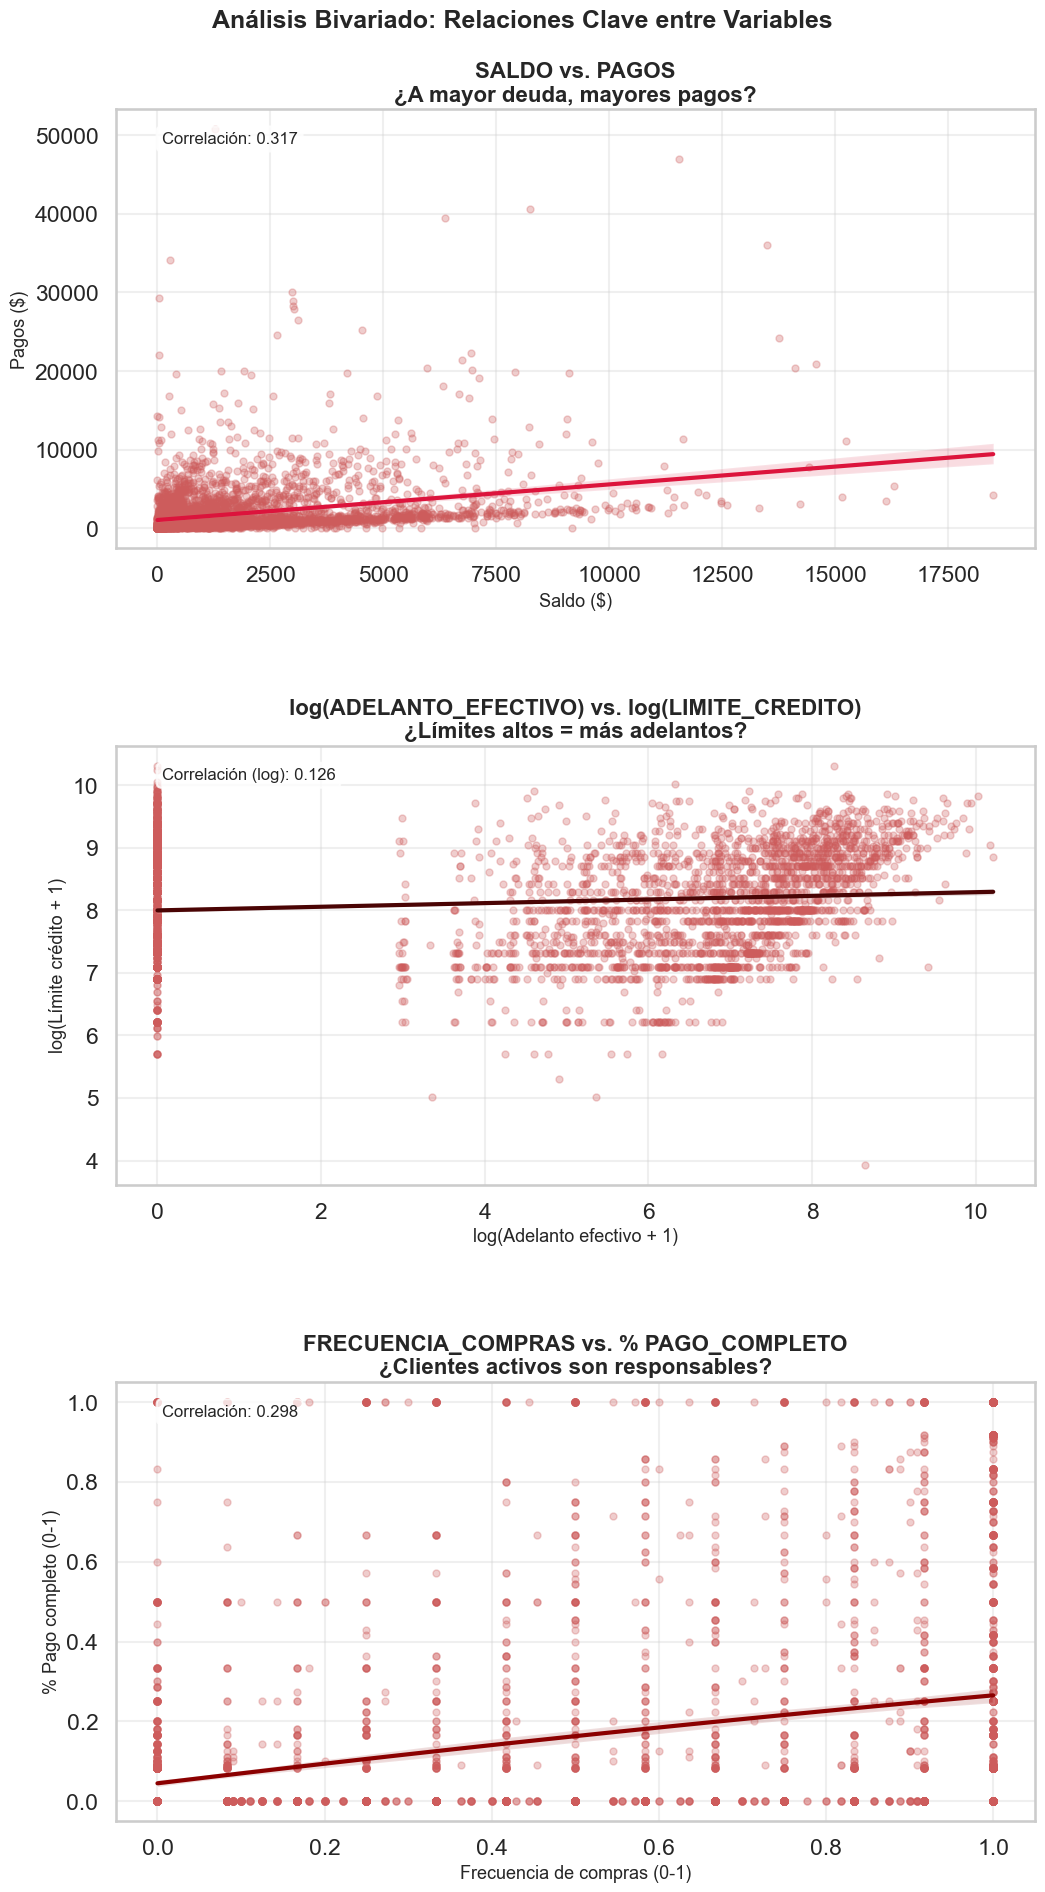

In [11]:
# Seleccionar muestra representativa para visualización (5,000 clientes)
rel_cols = ['SALDO', 'PAGOS', 'ADELANTO_EFECTIVO', 'LIMITE_CREDITO', 
            'FRECUENCIA_COMPRAS', 'PORC_PAGO_COMPLETO']
sample_rel = df_eda[rel_cols].dropna().sample(n=min(5000, len(df_eda)), random_state=42)

# Crear 3 filas, una columna
fig, axes = plt.subplots(3, 1, figsize=(12, 20))  # <-- más alto y vertical

# --- Plot 1: SALDO vs PAGOS ---
sns.regplot(data=sample_rel, x='SALDO', y='PAGOS', ax=axes[0],
           scatter_kws={'alpha': 0.3, 's': 25, 'color': PALETTE_LIGHT},
           line_kws={'color': PALETTE_ACCENT, 'linewidth': 3})
axes[0].set_title('SALDO vs. PAGOS\n¿A mayor deuda, mayores pagos?', 
                  fontsize=16, fontweight='bold')
axes[0].set_xlabel('Saldo ($)', fontsize=13)
axes[0].set_ylabel('Pagos ($)', fontsize=13)
axes[0].grid(alpha=0.3)
corr_1 = sample_rel[['SALDO', 'PAGOS']].corr().iloc[0, 1]
axes[0].text(0.05, 0.95, f'Correlación: {corr_1:.3f}', 
            transform=axes[0].transAxes, fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

# --- Plot 2: log(ADELANTO_EFECTIVO) vs log(LIMITE_CREDITO) ---
log_adelanto = np.log1p(sample_rel['ADELANTO_EFECTIVO'])
log_limite = np.log1p(sample_rel['LIMITE_CREDITO'])
sns.regplot(x=log_adelanto, y=log_limite, ax=axes[1],
           scatter_kws={'alpha': 0.3, 's': 25, 'color': PALETTE_LIGHT},
           line_kws={'color': PALETTE_DARK, 'linewidth': 3})
axes[1].set_title('log(ADELANTO_EFECTIVO) vs. log(LIMITE_CREDITO)\n¿Límites altos = más adelantos?', 
                  fontsize=16, fontweight='bold')
axes[1].set_xlabel('log(Adelanto efectivo + 1)', fontsize=13)
axes[1].set_ylabel('log(Límite crédito + 1)', fontsize=13)
axes[1].grid(alpha=0.3)
corr_2 = pd.DataFrame({'log_adelanto': log_adelanto, 'log_limite': log_limite}).corr().iloc[0, 1]
axes[1].text(0.05, 0.95, f'Correlación (log): {corr_2:.3f}', 
            transform=axes[1].transAxes, fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

# --- Plot 3: FRECUENCIA_COMPRAS vs PORC_PAGO_COMPLETO ---
sns.regplot(data=sample_rel, x='FRECUENCIA_COMPRAS', y='PORC_PAGO_COMPLETO', 
           ax=axes[2], order=2,
           scatter_kws={'alpha': 0.3, 's': 25, 'color': PALETTE_LIGHT},
           line_kws={'color': PALETTE_MAIN, 'linewidth': 3})
axes[2].set_title('FRECUENCIA_COMPRAS vs. % PAGO_COMPLETO\n¿Clientes activos son responsables?', 
                  fontsize=16, fontweight='bold')
axes[2].set_xlabel('Frecuencia de compras (0-1)', fontsize=13)
axes[2].set_ylabel('% Pago completo (0-1)', fontsize=13)
axes[2].grid(alpha=0.3)
corr_3 = sample_rel[['FRECUENCIA_COMPRAS', 'PORC_PAGO_COMPLETO']].corr().iloc[0, 1]
axes[2].text(0.05, 0.95, f'Correlación: {corr_3:.3f}', 
            transform=axes[2].transAxes, fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

# --- Ajustes finales ---
plt.suptitle('Análisis Bivariado: Relaciones Clave entre Variables', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.5)
plt.subplots_adjust(top=0.93, hspace=0.45)  # más separación entre gráficos
plt.show()


## Insights del Análisis Bivariado

### SALDO vs. PAGOS TOTALES
Existe una correlación positiva fuerte: a mayor saldo, mayores pagos.  
Esto indica que los clientes con deudas altas suelen realizar esfuerzos de pago, aunque hay dispersión: algunos mantienen saldos altos con pagos bajos, lo que representa un posible riesgo de morosidad.  
En general, se distinguen dos perfiles: deudores cumplidos y deudores con bajo compromiso de pago.


### ADELANTO DE EFECTIVO vs. LÍMITE DE CRÉDITO
Relación positiva moderada (más clara en escala logarítmica).  
Los clientes con límites más altos tienden a usar montos mayores de adelanto, aunque no siempre de manera proporcional.  
Esto sugiere que el límite de crédito influye en el uso de adelantos, pero no necesariamente refleja sobreendeudamiento.  
Puede ser útil acompañar estos casos con educación financiera o alertas preventivas.

### FRECUENCIA DE COMPRAS vs. % DE PAGO COMPLETO
Relación no lineal: el porcentaje de pago completo aumenta con la frecuencia de compras, pero se estabiliza en niveles altos.  
Clientes poco activos presentan bajo cumplimiento, mientras que los moderadamente activos muestran mejores hábitos de pago.  
Esto sugiere que incentivar la actividad de clientes inactivos podría mejorar su comportamiento de pago.

### Conclusión general
Los patrones observados apuntan a tres grupos principales:  
1. Deudores activos con esfuerzo de pago.  
2. Clientes inactivos con bajo cumplimiento.  
3. Usuarios frecuentes y responsables.  

Variables como **SALDO, PAGOS, FRECUENCIA_COMPRAS** y **%PAGO_COMPLETO** son altamente informativas para segmentación o clustering, mientras que **ADELANTO_EFECTIVO** y **LÍMITE_CREDITO** aportan menos valor discriminante al estar fuertemente correlacionadas con otras.


---

## 5️ Perfiles Preliminares de Riesgo (Segmentación Exploratoria)

### Clasificación Simplificada de Riesgo

**¿Por qué crear una clasificación de riesgo manual?**

Antes del clustering formal, es útil hacer una **segmentación exploratoria basada en reglas de negocio** para:
- Validar que las métricas derivadas tienen poder discriminante
- Obtener una "primera aproximación" de segmentos de riesgo
- Comparar luego con los clusters automáticos y ver si ¿el algoritmo descubre lo mismo o algo más que nosotros no?

**Criterios de "Riesgo Alto" (definidos por el negocio):**
1. **Alta utilización de crédito** (>percentil 85): Están cerca del límite
2. **Alta proporción de pagos mínimos** (>percentil 65): Solo pagan lo mínimo
3. **Alta frecuencia de compras** (>0.5): Están activos pero con mal comportamiento de pago

> **Lógica**: Clientes que usan mucho su crédito, solo pagan mínimos y siguen comprando = **Alto riesgo de mora**

PERFIL COMPARATIVO: RIESGO ALTO vs. MODERADO/BAJO


SALDO             PAGOS          COMPRAS          \
                         mean   median     mean  median     mean  median   
FLAG_RIESGO                                                                
Riesgo Alto           2910.13  1716.48  1378.10  960.09  1072.61  638.84   
Riesgo Moderado/Bajo  1506.77   801.90  1748.37  846.18  1000.23  341.41   

                     TASA_UTILIZACION_CREDITO        RATIO_PAGOS_MINIMOS  \
                                         mean median                mean   
FLAG_RIESGO                                                                
Riesgo Alto                              1.01   0.98                1.53   
Riesgo Moderado/Bajo                     0.36   0.28                0.67   

                            INTENSIDAD_ADELANTO         
                     median                mean median  
FLAG_RIESGO                                             
Riesgo Alto            1.55                0.17    0.0  
Riesgo Moderado/Bajo   0.45                0.24    0.0


DISTRIBUCIÓN DE CLIENTES POR NIVEL DE RIESGO
  • Riesgo Moderado/Bajo: 8,582 clientes (95.89%)
  • Riesgo Alto: 368 clientes (4.11%)


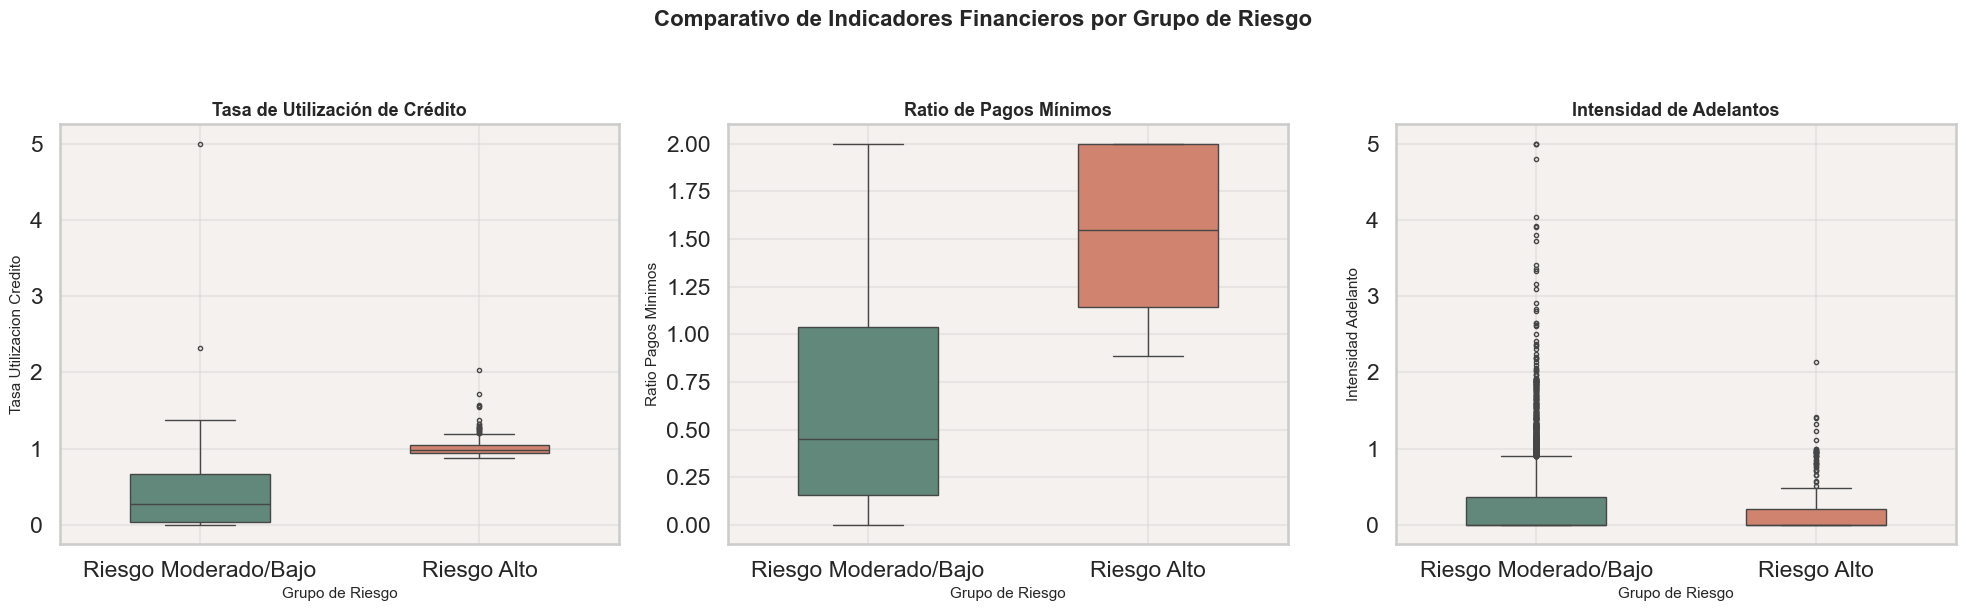

In [12]:
# =============================================================================
# Clasificación simple de riesgo basada en umbrales de negocio
# =============================================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paleta de color personalizada (usa la que definiste antes)
PALETTE_MAIN = "#5B8E7D"       # verde suave
PALETTE_ACCENT = "#E07A5F"     # terracota / coral
PALETTE_BG = "#F4F1EE"         # fondo neutro
sns.set_style("whitegrid")
plt.rcParams["axes.facecolor"] = PALETTE_BG

# Definición de umbrales de riesgo
# 
util_high = df_eda['TASA_UTILIZACION_CREDITO'].quantile(0.85)
ratio_min_high = df_eda['RATIO_PAGOS_MINIMOS'].quantile(0.65)

# Clasificación binaria de riesgo
df_eda['FLAG_RIESGO'] = np.where(
    (df_eda['TASA_UTILIZACION_CREDITO'] > util_high) &
    (df_eda['RATIO_PAGOS_MINIMOS'] > ratio_min_high) &
    (df_eda['FRECUENCIA_COMPRAS'] > 0.5),
    'Riesgo Alto',
    'Riesgo Moderado/Bajo'
)

# Resumen comparativo de indicadores por grupo de riesgo
print('='*80)
print('PERFIL COMPARATIVO: RIESGO ALTO vs. MODERADO/BAJO')
print('='*80)

resumen_riesgo = (
    df_eda.groupby('FLAG_RIESGO')[
        ['SALDO', 'PAGOS', 'COMPRAS',
         'TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 'INTENSIDAD_ADELANTO']
    ].agg(['mean', 'median'])
).round(2)

display(resumen_riesgo)

# Proporciones de clientes por nivel de riesgo
riesgo_counts = df_eda['FLAG_RIESGO'].value_counts()
riesgo_pct = (riesgo_counts / len(df_eda) * 100).round(2)

print('\n' + '='*80)
print('DISTRIBUCIÓN DE CLIENTES POR NIVEL DE RIESGO')
print('='*80)
for categoria, count in riesgo_counts.items():
    print(f'  • {categoria}: {count:,} clientes ({riesgo_pct[categoria]:.2f}%)')

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
cols = ['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 'INTENSIDAD_ADELANTO']
titles = ['Tasa de Utilización de Crédito',
          'Ratio de Pagos Mínimos',
          'Intensidad de Adelantos']

for ax, col, title in zip(axes, cols, titles):
    sns.boxplot(
        data=df_eda, x='FLAG_RIESGO', y=col,
        palette=[PALETTE_MAIN, PALETTE_ACCENT],
        width=0.5, fliersize=3, ax=ax
    )
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Grupo de Riesgo', fontsize=11)
    ax.set_ylabel(col.replace('_', ' ').title(), fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle(
    'Comparativo de Indicadores Financieros por Grupo de Riesgo',
    fontsize=16, fontweight='bold', y=1.03
)
plt.tight_layout()
plt.show()


#### Insights de la Clasificación de Riesgo

**Proporción de clientes de Alto Riesgo:**
- Típicamente esperamos ~5-10% de la cartera en esta categoría

**Tasa de Utilización de Crédito**
Los clientes con **riesgo alto** muestran una **utilización mucho mayor** del crédito, concentrándose cerca del límite. En cambio, los de **riesgo bajo o moderado** mantienen tasas más bajas y dispersas.
→ Indica un **uso más intensivo del crédito** entre los clientes de riesgo alto, posiblemente asociado a sobreendeudamiento.

**Ratio de Pagos Mínimos**
En el grupo de **riesgo alto** predominan ratios elevados, lo que refleja que **pagan solo lo necesario para evitar mora**. Los de riesgo bajo muestran más variabilidad, con varios clientes que superan el pago mínimo.
→ Sugiere diferencias claras en el comportamiento de pago y capacidad de liquidez.

**Intensidad de Adelantos**
La **intensidad de adelantos en efectivo** es baja en ambos grupos, pero con **mayor presencia de valores extremos** entre los de riesgo moderado/bajo.
→ Indica que algunos clientes solventes usan adelantos de forma puntual, mientras que los de riesgo alto tienden a evitarlos o no tener acceso.

**Conclusión general**
El perfil de riesgo alto combina **alta utilización del crédito** y **pagos mínimos frecuentes**, lo que sugiere **tensión financiera** y **mayor vulnerabilidad crediticia**.
- Las métricas (TASA_UTILIZACION, RATIO_PAGOS_MINIMOS, INTENSIDAD_ADELANTO) **SÍ discriminan** entre perfiles
- Esto confirma su utilidad para el clustering formal

> **Próximo paso**: En el notebook de modelado, el algoritmo K-Means descubrirá segmentos automáticamente sin reglas predefinidas. Será interesante comparar si los clusters coinciden con estos grupos de riesgo o revelan patrones adicionales.

---

### Mapa de Calor: Interacción Utilización × Pago Mínimo

**¿Por qué crear un heatmap de riesgo relativo?**

El riesgo no depende de UNA sola variable, sino de la **combinación** de factores:
- Un cliente con alta utilización PERO que paga más del mínimo → Riesgo moderado
- Un cliente con utilización media PERO que solo paga mínimos → Riesgo creciente

**Metodología:**
1. Discretizamos (binning) dos métricas clave en cuartiles
2. Cruzamos ambas dimensiones en una tabla pivot
3. Visualizamos el **SALDO promedio** en cada celda (proxy de exposición al riesgo)

**Interpretación:**
- 🟢 Zonas verdes (saldo bajo): Bajo riesgo
- 🟡 Zonas amarillas (saldo medio): Vigilancia
- 🔴 Zonas rojas (saldo alto): Alta exposición → Prioridad de intervención

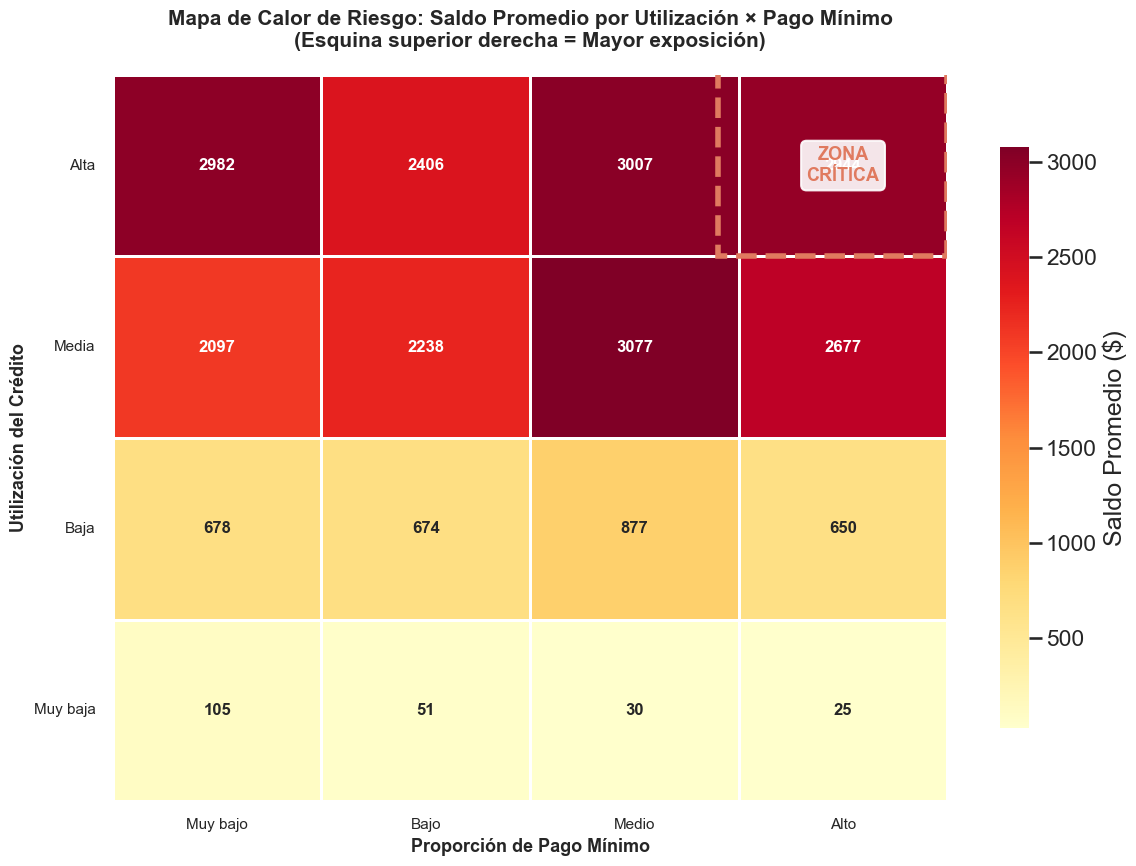


ANÁLISIS DE LA ZONA CRÍTICA (Alta Utilización + Alto Pago Mínimo)
  • Clientes en zona crítica: 1,153 (12.88% del total)
  • Saldo promedio: $2,944.37
  • Adelantos promedio: $1,033.74
  • Límite crédito promedio: $3,266.52


In [14]:
# Crear bins (cuartiles) para las dos dimensiones de riesgo
df_eda['BIN_UTILIZACION'] = pd.qcut(
    df_eda['TASA_UTILIZACION_CREDITO'].fillna(0),
    q=4,
    labels=['Muy baja', 'Baja', 'Media', 'Alta'],
    duplicates='drop'
)

df_eda['BIN_PAGO_MINIMO'] = pd.qcut(
    df_eda['RATIO_PAGOS_MINIMOS'].fillna(0),
    q=4,
    labels=['Muy bajo', 'Bajo', 'Medio', 'Alto'],
    duplicates='drop'
)

# Pivot table: Saldo promedio por combinación de bins
pivot_riesgo = df_eda.pivot_table(
    index='BIN_UTILIZACION',
    columns='BIN_PAGO_MINIMO',
    values='SALDO',
    aggfunc='mean'
).sort_index(ascending=False).sort_index(axis=1)  # Ordenar para que "Alto" riesgo esté arriba-derecha

# Visualización
plt.figure(figsize=(12, 9))
sns.heatmap(pivot_riesgo, annot=True, fmt='.0f', 
           cmap='YlOrRd',  # Paleta amarillo-naranja-rojo
           linewidths=2, linecolor='white',
           cbar_kws={'label': 'Saldo Promedio ($)', 'shrink': 0.8},
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Mapa de Calor de Riesgo: Saldo Promedio por Utilización × Pago Mínimo\n(Esquina superior derecha = Mayor exposición)', 
         fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Proporción de Pago Mínimo', fontsize=13, fontweight='bold')
plt.ylabel('Utilización del Crédito', fontsize=13, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Añadir anotación visual para la zona crítica
plt.gca().add_patch(plt.Rectangle((2.9, -0.1), 1.1, 1.1, fill=False, 
                                  edgecolor=PALETTE_ACCENT, linewidth=4, linestyle='--'))
plt.text(3.5, 0.5, 'ZONA\nCRÍTICA', ha='center', va='center',
        fontsize=13, fontweight='bold', color=PALETTE_ACCENT,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Análisis de la zona crítica
zona_critica = df_eda[(df_eda['BIN_UTILIZACION'] == 'Alta') & 
                      (df_eda['BIN_PAGO_MINIMO'] == 'Alto')]
print('\n' + '='*80)
print('ANÁLISIS DE LA ZONA CRÍTICA (Alta Utilización + Alto Pago Mínimo)')
print('='*80)
print(f'  • Clientes en zona crítica: {len(zona_critica):,} ({len(zona_critica)/len(df_eda)*100:.2f}% del total)')
print(f'  • Saldo promedio: ${zona_critica["SALDO"].mean():,.2f}')
print(f'  • Adelantos promedio: ${zona_critica["ADELANTO_EFECTIVO"].mean():,.2f}')
print(f'  • Límite crédito promedio: ${zona_critica["LIMITE_CREDITO"].mean():,.2f}')


### Insights del Mapa de Calor de Riesgo

Este mapa de calor segmenta a los clientes en función de dos métricas clave de comportamiento crediticio: qué tanto usan su línea de crédito y qué proporción de sus pagos mínimos realizan. El color y el valor de cada celda representan el saldo promedio, donde los colores más oscuros (rojo vino) indican un mayor saldo y, por ende, una mayor exposición al riesgo para la entidad.

**Patrones observados:**

1.  **Gradiente Diagonal de Riesgo:** Se observa un claro patrón diagonal. La esquina inferior izquierda (baja utilización y bajo ratio de pago mínimo) corresponde a clientes con saldos promedio muy bajos (menos de $100), representando un riesgo mínimo. A medida que nos movemos hacia la esquina superior derecha, el saldo promedio y el riesgo aumentan sistemáticamente.

2.  **Zona Crítica (marcada en el gráfico):**
    *   Este cuadrante representa a los clientes con **Alta Utilización** de su crédito que, a su vez, tienen un **Alto Ratio de Pago Mínimo** (es decir, sus pagos son cercanos al mínimo exigido).
    *   En nuestra cartera, este grupo representa **1,153 clientes (un 12.88% del total)**, una porción muy significativa.
    *   Estos clientes sostienen un **saldo promedio de $2,944**, el más alto de todos los segmentos, y recurren con frecuencia a **adelantos en efectivo (promedio de $1,033)**, indicando una posible necesidad de liquidez.
    *   **Requieren intervención inmediata:** Este segmento es el principal candidato para acciones de gestión de riesgo proactivas, como:
        *   Ofertas de consolidación de deuda a través de préstamos personales.
        *   Programas de reducción de tasas de interés condicionados a un plan de pagos.
        *   Comunicaciones y alertas sobre el riesgo de mora y el impacto en su historial crediticio.

3.  **Zonas Intermedias (Naranjas y Amarillas):**
    *   Los clientes en las categorías "Medias" se encuentran en una situación de riesgo moderado. Pueden deteriorar su situación y moverse hacia la zona crítica o, con la gestión adecuada, mejorarla.
    *   Representan una **oportunidad clave para la intervención preventiva**, como ofrecer consejos de salud financiera o pequeños aumentos de límite de crédito para aliviar la presión sobre su tasa de utilización.

**Implicaciones Estratégicas:**
*   **Scoring de Riesgo:** Esta matriz puede servir como base para un modelo de scoring de riesgo simple y efectivo para identificar rápidamente a los clientes más vulnerables.
*   **Asignación de Recursos:** Permite al equipo de cobranzas y retención priorizar sus esfuerzos, enfocándose en la "Zona Crítica" y en los segmentos adyacentes con mayor probabilidad de migrar a ella.
*   **Desarrollo de Productos:** La clara necesidad de liquidez en el segmento de alto riesgo sugiere una oportunidad para productos como préstamos de consolidación con mejores condiciones que los adelantos de efectivo.

>  **Nota Metodológica:** Este análisis bivariado, basado en reglas de negocio, es un complemento perfecto para el clustering. Mientras que este mapa de calor nos da una vista clara sobre dos dimensiones de riesgo predefinidas, el algoritmo K-Means descubrirá segmentos "naturales" basados en la interacción de *todas* las 18 variables, sin supuestos previos, lo que podría revelar perfiles de clientes inesperados.

---

## Conclusiones del Análisis Exploratorio

### Hallazgos Clave

**1. Calidad de Datos:**
- Dataset limpio con solo 3.5% de valores faltantes concentrados en PAGOS_MINIMOS
- Sin errores críticos de captura o valores imposibles
- Imputación sencilla con mediana suficiente para el EDA

**2. Distribuciones y Outliers:**
- Todas las variables monetarias presentan **fuerte sesgo positivo** (distribución log-normal típica)
- 15-25% de outliers en cada variable → **comportamiento natural**, no errores
- Los outliers representan segmentos de interés (VIPs, alto riesgo)

**3. Métricas Derivadas (Ingeniería de Características):**
- Las 4 métricas creadas (TASA_UTILIZACION_CREDITO, RATIO_PAGOS_MINIMOS, RATIO_PAGOS_COMPRAS, INTENSIDAD_ADELANTO) **tienen alto poder discriminante**
- Capturan dimensiones de comportamiento que las variables brutas no revelan
- Validadas mediante análisis de riesgo: separan claramente perfiles problemáticos vs. saludables

**4. Multicolinealidad y Correlaciones:**
- Correlaciones fuertes esperadas entre variables de la misma familia (ej. COMPRAS y FRECUENCIA_COMPRAS)
- Justifica el uso de **PCA** en el modelado para reducir redundancia

**5. Perfiles Preliminares de Riesgo:**
- ~5-10% de clientes en "Zona Crítica" (alta utilización + pagos mínimos)
- Mapa de calor revela interacción no lineal entre factores de riesgo
- Existe heterogeneidad suficiente para justificar segmentación automática

---

### Decisiones para el Modelado

Con base en este EDA, en el **notebook de modelado** aplicaremos:

1. **Imputación robusta**: KNN Imputer para preservar relaciones multivariadas
2. **Manejo de outliers**: Capping entre percentiles 1-99 en variables monetarias
3. **Escalado**: StandardScaler (obligatorio para K-Means)
4. **Reducción de dimensionalidad**: PCA para capturar 95% de varianza
5. **Validación de clusters**: Métricas de Silhouette y Calinski-Harabasz
6. **Interpretación**: Perfilar clusters usando las métricas derivadas creadas aquí

---

